In [1]:
from PIL import Image
import os
import pathlib
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle as sk_shuffle
from skimage.util import random_noise
from skimage import measure
import time
import os

import matplotlib.pyplot as plt

from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler


import glob2
import pdb
import ipdb

In [2]:

SEED = 42


labels_dict = {'1':1, '2':2, '3':3, '4':4, '5':5,
               '6':6, '7':7, '8':8, '9':9, '10':10,
               '11':11, '12':12, '13':13, '14':14, '15':15,
               '16':16, '17':17, '18':18, '19':19, '20':20,
               '21':21, '22':22, '23':23, '24':24, '25':25,
               '26':26, '27':27, '28':28, '29':29, '30':30,
               '31':31, '32':32, 'a':33, 'b':34, 'c':35, 'd':36,
               'e':37, 'f':38, 'g':39, 'h':40, 'i':41, 'j':42, 'k':43,
               'l':44, 'm':45, 'n':46, 'o':47, 'p':48, 'q':49, 'r':50, 's':51, 't':52,
               'conecut':53, 'caries':54, 'caries2':54,'caries3':54,'crown':55, 'bridge':56,
               'gutta-percha':57, 'pin':58, 'post':59, 'buildup':60, 'calculus':61, 'sealer':62,
               'cement':63, 'bracket':64, 'retainer':65, 'instrument':66, 'implant':67, 'screw':68,
               'veneer':69, 'silver-point':70, 'space-maintainer':71, 'core':72, 'base':73,
               'temporary-filling':74, 'medicament':75, 'framework':76, 'liner':77, 'onlay-composite':78,
               'onlay-metal':79, 'onlay-ceramic':80, 'inlay-ceramic':81, 'inlay-composite':82, 'inlay-metal':83,
               'filling-composite':84, 'filling-glass':85, 'filling-metal':86}

reverse_labels_dict = {v: k for k, v in labels_dict.items()}

labels_dict_no_baby = {'1':1, '2':2, '3':3, '4':4, '5':5,
               '6':6, '7':7, '8':8, '9':9, '10':10,
               '11':11, '12':12, '13':13, '14':14, '15':15,
               '16':16, '17':17, '18':18, '19':19, '20':20,
               '21':21, '22':22, '23':23, '24':24, '25':25,
               '26':26, '27':27, '28':28, '29':29, '30':30,
               '31':31, '32':32, 'conecut':33, 'caries':34, 'caries2':34,'caries3':34}
regions_dict_all = {'Anterior1MandibleB':0,
               'Anterior2MaxillaL':1,
               'Anterior2MaxillaR':2,
               'Anterior3MandibleL':3,
               'Anterior3MandibleR':4,
               'Anterior3MaxillaL':5,
               'Anterior3MaxillaR':6,
               'Molar3JawregionL':7,
               'Molar3JawregionR':8,
               'Molar3MandibleL':9,
               'Molar3MandibleR':10,
               'Molar3MaxillaL':11,
               'Molar3MaxillaR':12,
               'Anterior1MandibleL':13,
               'Premolar2JawregionR':14,
               'Premolar2MandibleR':15,
               'Premolar2MaxillaL':16,
               'Premolar2MaxillaR':17,
               'Anterior1MaxillaB':18,
               'Premolar2MandibleL':19,
               'Premolar2JawregionL':20,
               'Anterior1MaxillaR':21,
               'Anterior1MaxillaL':22,
               'Anterior2MaxillaB':23,
               'Anterior2MandibleL':24,
               'Anterior1MandibleR':25}

regions_dict_standard = {'Anterior2MaxillaR':0,
                         'Anterior3MaxillaR':1,
                         'Anterior1MandibleB':2,
                         'Molar3MandibleR':3,
                         'Molar3MaxillaL':4,
                         'Anterior2MaxillaL':5,
                         'Anterior3MaxillaL':6,
                         'Molar3MaxillaR':7,
                         'Anterior3MandibleL':8,
                         'Premolar2MaxillaL':9,
                         'Premolar2MandibleR':10,
                         'Premolar2MandibleL':11,
                         'Molar3JawregionL':12,
                         'Anterior3MandibleR':13,
                         'Molar3JawregionR':14,
                         'Premolar2JawregionL':15,
                         'Premolar2JawregionR':16,
                         'Premolar2MaxillaR':17,
                         'Anterior1MaxillaB':18,
                         'Molar3MandibleL':19}
tooth_dict = {'1':1, '2':2, '3':3, '4':4, '5':5,
               '6':6, '7':7, '8':8, '9':9, '10':10,
               '11':11, '12':12, '13':13, '14':14, '15':15,
               '16':16, '17':17, '18':18, '19':19, '20':20,
               '21':21, '22':22, '23':23, '24':24, '25':25,
               '26':26, '27':27, '28':28, '29':29, '30':30,
               '31':31, '32':32, 'a':33, 'b':34, 'c':35, 'd':36,
               'e':37, 'f':38, 'g':39, 'h':40, 'i':41, 'j':42, 'k':43,
               'l':44, 'm':45, 'n':46, 'o':47, 'p':48, 'q':49, 'r':50, 's':51, 't':52}

prior_dict = {'crown':1, 'bridge':2,
               'gutta-percha':3, 'pin':4, 'post':5, 'buildup':6, 'calculus':7, 'sealer':8,
               'cement':9, 'bracket':10, 'retainer':11, 'instrument':12, 'implant':13, 'screw':14,
               'veneer':15, 'silver-point':16, 'space-maintainer':17, 'core':18, 'base':19,
               'temporary-filling':20, 'medicament':21, 'framework':22, 'liner':23, 'onlay-composite':24,
               'onlay-metal':25, 'onlay-ceramic':26, 'inlay-ceramic':27, 'inlay-composite':28, 'inlay-metal':29,
               'filling-composite':30, 'filling-glass':31, 'filling-metal':32}

reverse_prior_dict = {v: k for k, v in prior_dict.items()}

filling_dict = {'temporary-filling':1, 'filling-composite':2, 'filling-glass':3, 'filling-metal':4}
reverse_filling_dict = {v: k for k, v in filling_dict.items()}

majority_dict = {'crown':1, 'bridge':1, 'temporary-filling':2, 'filling-composite':2, 'filling-glass':2, 'filling-metal':2 , 'onlay-composite':2,
               'onlay-metal':2, 'onlay-ceramic':2, 'inlay-ceramic':2, 'inlay-composite':2, 'inlay-metal':2} 
reverse_majority_dict = {1:'crown', 2:'restorative'}


prior_dict = {'crown':1, 'bridge':2,
               'gutta-percha':3, 'pin':4, 'post':5, 'buildup':6, 'calculus':7, 'sealer':8,
               'cement':9, 'bracket':10, 'retainer':11, 'instrument':12, 'implant':13, 'screw':14,
               'veneer':15, 'silver-point':16, 'space-maintainer':17, 'core':18, 'base':19,
               'temporary-filling':20, 'medicament':21, 'framework':22, 'liner':23, 'onlay-composite':24,
               'onlay-metal':25, 'onlay-ceramic':26, 'inlay-ceramic':27, 'inlay-composite':28, 'inlay-metal':29,
               'filling-composite':30, 'filling-glass':31, 'filling-metal':32}

reverse_prior_dict = {v: k for k, v in prior_dict.items()}


colors_dict ={

  '1':'#ff7b00','2':'#0073ff','3':'#ffce00','4':'#00efff',

  '5':'#0800ff','6':'#ffa600','7':'#8cff00','8':'#fff700',

  '9':'#5a00ff','10':'#004aff','11':'#ff8800','12':'#ff00e6',

  '13':'#63ff00','14':'#ad00ff','15':'#00ffbd','16':'#ff0000',

  '17':'#00c5ff','18':'#10ff00','19':'#d600ff','20':'#00ff94',

  '21':'#8400ff','22':'#0088ff','23':'#3aff00','24':'#ff2900',

  '25':'#deff00','26':'#3100ff','27':'#ffaa00','28':'#00ff19',

  '29':'#00ffe6','30':'#0021ff','31':'#b5ff00','32':'#ff5200',

  'a':'#ff7b88','b':'#007388','c':'#ffce88','d':'#00ef88',

  'e':'#080088','f':'#ffa688','g':'#8cff88','h':'#fff788',

  'i':'#5a0088','j':'#004a88','k':'#ff8888','l':'#ff00e6',

  'm':'#63ff88','n':'#ad0088','o':'#00ffbd','p':'#ff0088',

  'q':'#00c588','r':'#10ff88','s':'#d60088','t':'#00ff94',

  'conecut':'#00fbff',

  'caries':'#ff0000',

  'caries2':'#800080',
  'caries3':'#800080',  

'crown':'#CDFF00',
'bridge':'#9EFF00',
'gutta-percha':'#00FFA6',
'pin':'#00FFD8',
'post':'#00E0FF',
'buildup':'#00A2FF',
'calculus':'#0042FF',
'sealer':'#8000FF',
'cement':'#00ff44',
'bracket':'#84ff00',
'retainer':'#ffcc00',
'instrument':'#458cff',
'implant':'#c145ff',
'screw':'#ec45ff',
'veneer':'#ff45f3',
'silver-point':'#ff45d1',
'space-maintainer':'#ff45ae',
'core':'#ff4589',
'base':'#ff4548',
'temporary-filling':'#ff6145',
'medicament':'#ff7a45',
'framework':'#ff9c45',
'liner':'#e3ff45',
'onlay-composite':'#fff045',
'onlay-metal':'#fff045',
'onlay-ceramic': '#fff045',
'inlay-ceramic':'#ffbe45',
'inlay-composite':'#ffbe45',
'inlay-metal':'#ffbe45',
'filling-composite':'#FF00E8',
'filling-glass':'#FF00E8',
'filling-metal':'#FF00E8'    
}


filling_cdict = {'temporary-filling':'#ff6145',
'filling-composite':'#ff8e45',
'filling-glass':'#FF00E8',
'filling-metal':'#ff3c45'  }

majority_cdict = {'restorative': '#ff3c45', 'crown':'#CDFF00' }





In [15]:
class retrace_parser():
    def __init__(self,dataset_path):
        self.images_root_path = os.path.join(dataset_path,'images')
        self.masks_root_path = os.path.join(dataset_path,'masks')
        #self.args = args

    def create_dataset(self):
        train_root = pathlib.Path(self.images_root_path)
        # Train and Test Paths 
        image_paths_train = []
        
        # use only standard views
        for std_view in regions_dict_standard:
            pathk = '*/' + std_view + '/im.jpg'
            image_paths_train += list(train_root.glob(pathk))

        all_imgs_ = sorted([str(path) for path in image_paths_train])
        all_masks = []
        all_imgs = []
        for i,im_path in enumerate(all_imgs_):
            mask_path = im_path.replace('images','masks')
            mask_path = pathlib.Path(mask_path[:-7])
            mask_paths_ = list(mask_path.glob('*.jpg'))
            mask_paths = sorted([str(path) for path in mask_paths_])
            
            # not use images with baby teeth
#             has_babies=False
#             for m in mask_paths:
#                 label_name = m.split('/')[-1].split('.')[0]
#                 if labels_dict[label_name] >32 and labels_dict[label_name] <53:
#                     has_babies=True

#             if has_babies==False:
            all_masks.append(mask_paths)
            all_imgs.append(im_path)
        print('Dataset length: ',len(all_imgs))
        return all_imgs,all_masks
    
class retrace_parser_synth():
    def __init__(self,dataset_path):
        self.images_root_path = os.path.join(dataset_path,'images')
        self.masks_root_path = os.path.join(dataset_path,'masks')
        #self.args = args

    def create_dataset(self):
        train_root = pathlib.Path(self.images_root_path)
        # Train and Test Paths 
        image_paths_train = []
        
        # use only standard views
        for std_view in regions_dict_standard:
            pathk = '*/' + std_view + '/*/im.jpg'
            image_paths_train += list(train_root.glob(pathk))

        all_imgs_ = sorted([str(path) for path in image_paths_train])
        all_masks = []
        all_imgs = []
        for i,im_path in enumerate(all_imgs_):
            mask_path = im_path.replace('images','masks')
            mask_path = pathlib.Path(mask_path[:-7])
            mask_paths_ = list(mask_path.glob('*.jpg'))
            mask_paths = sorted([str(path) for path in mask_paths_])
            
            # not use images with baby teeth
#             has_babies=False
#             for m in mask_paths:
#                 label_name = m.split('/')[-1].split('.')[0]
#                 if labels_dict[label_name] >32 and labels_dict[label_name] <53:
#                     has_babies=True

#             if has_babies==False:
            all_masks.append(mask_paths)
            all_imgs.append(im_path)
        print('Dataset length synthetic: ',len(all_imgs))
        return all_imgs,all_masks


class RetraceDataLoader(Dataset):
    def __init__(self, root_dir,root_dir_synth=None, image_size=(384,384), length = 'all', transform=None, crop=False):
#         ipdb.set_trace()
        rp = retrace_parser(root_dir)
        image_paths,label_paths = rp.create_dataset()
        
        if length!='all':
            image_paths = image_paths[:length]
            label_paths = label_paths[:length]
        
        self.label_paths = label_paths
        self.image_paths = image_paths

        size = len(self.image_paths)
        self.dataset_size = size
        self.image_size = image_size
        self.transform=transform
        self.crop = crop
        
        
        self.dataset_synth_size = 0
        if root_dir_synth!=None:
            rp_synth = retrace_parser_synth(root_dir_synth)
            self.image_paths_synth,self.label_paths_synth = rp_synth.create_dataset()
            self.dataset_synth_size = len(self.image_paths_synth)
            
    def five_crops(self, img, mask):
        
        crop_height = 256
        crop_width = 256
        
        img_h, img_w = img.shape #img_ch, 
        assert img_h> crop_height
        assert img_w> crop_width
        
        center_x = (img_w-crop_width)//2
        center_y = (img_h-crop_height)//2
        crop_list = ['tl','tr','bl','br','center']
        crop_type = random.choice(crop_list)
        
        def get_crops(image, crop_type ,crop_height, crop_width, center_x, center_y):
            
            if crop_type == 'tl':
                img = image[:crop_height, :crop_width]
            if crop_type == 'tr':
                img = image[:crop_height, img_w-crop_width:]
            if crop_type == 'bl':
                img = image[img_h-crop_height:, :crop_width]
            if crop_type == 'br':
                img = image[img_h-crop_height:, img_w-crop_width:]
            if crop_type == 'center':
                img = image[center_y:-center_y, center_x:-center_x]
            
            return img
        
        imgs = get_crops(img, crop_type, crop_height, crop_width, center_x, center_y)
        masks = get_crops(mask, crop_type, crop_height, crop_width, center_x, center_y)
        
        return imgs, masks
    
    
    def vflip(self, img, mask):
        
        img = np.flipud(img)
        mask = np.flipud(mask)
            
        return img, mask
    
    def hflip(self, img, mask):
        
        img = np.fliplr(img)
        mask = np.fliplr(mask)
        
        return img, mask

    def __getitem__(self, index):
        synth_mode = False
        if random.choice(range(3)) <2 or self.dataset_synth_size==0:            
            # normal image
            image_path = self.image_paths[index]
            # masks paths
            label_path = self.label_paths[index]
        else:
            synth_mode = True
            # synthetic image
            offset = random.choice(range(0,5))
            synth_idx = index*5+offset
            if (synth_idx>=self.dataset_synth_size):
                synth_idx = random.choice(range(0,self.dataset_synth_size-1+1))
            # synth image
            image_path = self.image_paths_synth[synth_idx]
            # synth masks paths
            label_path = self.label_paths_synth[synth_idx]
           
        idx_region =1 if 'synthetic' in image_path else 0
            

        # labels
        labels_teeth = np.zeros(shape=[34])
        labels_region = np.zeros(shape=[1])#20
        # masks
        masks = np.zeros(shape=[1,self.image_size[0],self.image_size[1]]) #35 channels -> 0 is background
#         ipdb.set_trace()
        m_path = []
        for m in label_path:
            label_name = m.split('/')[-1].split('.')[0]
#             if label_name in list(tooth_dict.keys()):
#                 mask = cv2.imread(m,0)
#                 mask = cv2.resize(mask, (self.image_size[1],self.image_size[0]),
#                                         interpolation = cv2.INTER_NEAREST)
#                 mask[mask>=0.5]=1
#                 mask[mask<0.5]=0
#                 masks[0,:,:]+=mask
            if 'caries' in label_name: #list(majority_dict.keys()):
                
                mask = cv2.imread(m,0)
                mask = cv2.resize(mask, (self.image_size[1],self.image_size[0]),
                                        interpolation = cv2.INTER_NEAREST)
                mask[mask>=0.5]=1
                mask[mask<0.5]=0
                masks[0,:,:]+=mask
                m_path.append(m)
        
#         masks[:,:,:][masks[:,:,:]<1] = 0 
#         masks[:,:,:][masks[:,:,:]>=1] = 1
        if synth_mode == False:
            # for caries if 2 of 3 agree
            masks[0,:,:][masks[0,:,:]<=1] = 0 
            masks[0,:,:][masks[0,:,:]> 1] = 1
        else:
            # for caries if 2 of 3 agree
            masks[0,:,:][masks[0,:,:]<1] = 0 
            masks[0,:,:][masks[0,:,:]>=1] = 1

        # add bkgrd 
#         sum_all = np.sum(masks,axis=0)
#         masks[0,:,:][sum_all<1] == 1

        # set region label
        region_name = image_path.split('/')[-2-idx_region]
        labels_region= np.array(regions_dict_standard[region_name])
                

        # read xray as image
        image = cv2.imread(image_path,0)
        image = cv2.resize(image, (self.image_size[1],self.image_size[0]),
                                interpolation = cv2.INTER_AREA)

        # if you pass transform
        if self.transform:
            image = self.transform(image)

        # normalize image
        image = (image)/255.0
        
#         masks = np.squeeze(masks)
#         if self.crop:
#               image, masks = self.five_crops(image, masks)
# #         np.random.seed()

#         # Horizontal Flip
#         if random.choice(range(8)) > 3:
#             print('here')
#             image, masks = self.hflip(image, masks)
        
#         # Vertical Flip
#         if random.choice(range(8)) > 4:
#             print('here1')
#             image, masks = self.vflip(image, masks)
        
        
        image_tensor = torch.from_numpy(np.expand_dims(image,0)).float()
        teeth_tensor = torch.from_numpy(labels_teeth).float()
        region_tensor = torch.from_numpy(labels_region).long()
        mask_tensor = torch.from_numpy(masks).float()
        
        
        input_dict = {
                      'image': image_tensor,
                      'path': image_path,
                    'mask_path': m_path,
                      'masks': masks
                      }

        return input_dict

    def __len__(self):
        return self.dataset_size


Dataset length:  60178
Dataset length synthetic:  300885
/home/rohan/Datasets/synthetic_prior_clean/train/images/1.190926791160849.959...2.7110.0020707682.6516677236020001.735/Premolar2JawregionL/1/im.jpg
['/home/rohan/Datasets/synthetic_prior_clean/train/masks/1.190926791160849.959...2.7110.0020707682.6516677236020001.735/Premolar2JawregionL/1/caries.jpg', '/home/rohan/Datasets/synthetic_prior_clean/train/masks/1.190926791160849.959...2.7110.0020707682.6516677236020001.735/Premolar2JawregionL/1/caries3.jpg']


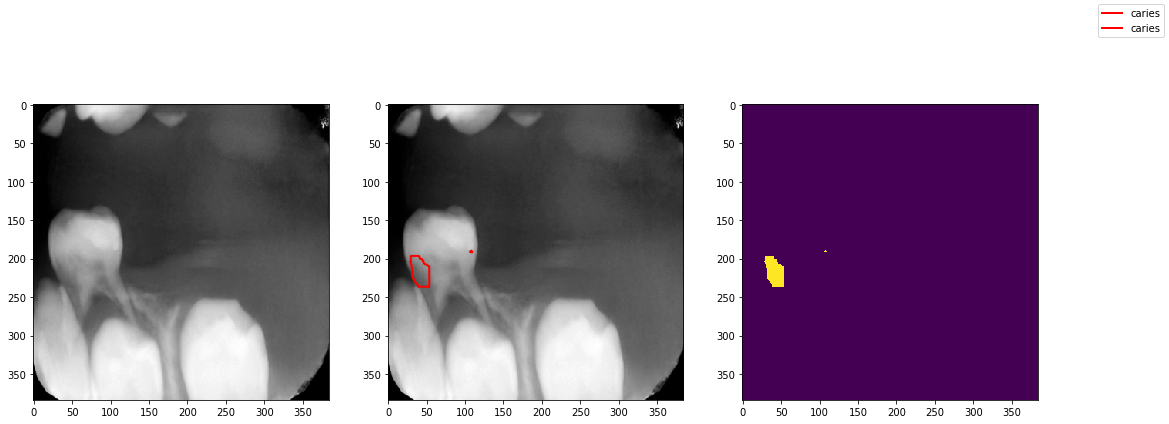

/home/rohan/Datasets/prior_clean/train/images/1.190926791160849.959...27404.45618687682615.627775..033815865/Anterior1MaxillaB/im.jpg
['/home/rohan/Datasets/prior_clean/train/masks/1.190926791160849.959...27404.45618687682615.627775..033815865/Anterior1MaxillaB/caries2.jpg', '/home/rohan/Datasets/prior_clean/train/masks/1.190926791160849.959...27404.45618687682615.627775..033815865/Anterior1MaxillaB/caries3.jpg']


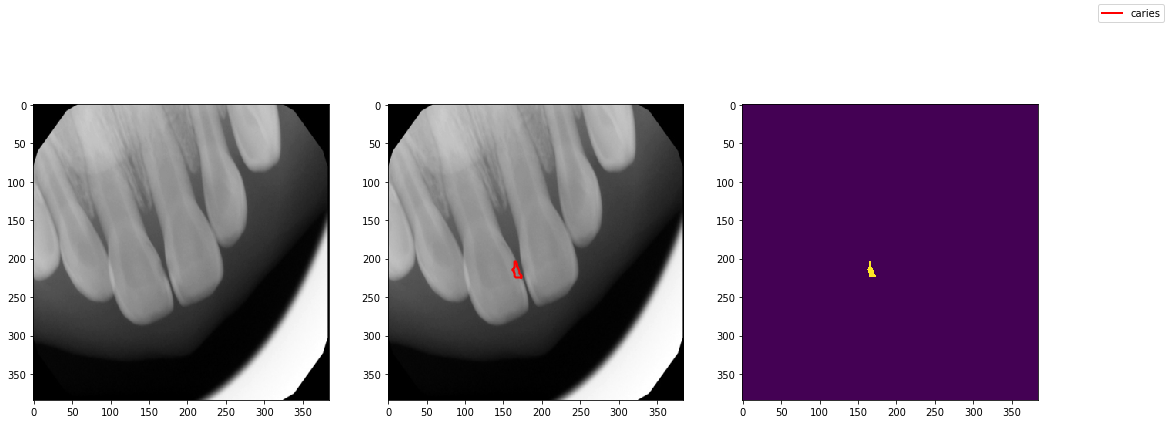

/home/rohan/Datasets/synthetic_prior_clean/train/images/1.190926791160849.959...27404.45618687682615.627775..033815865/Molar3JawregionL/3/im.jpg
['/home/rohan/Datasets/synthetic_prior_clean/train/masks/1.190926791160849.959...27404.45618687682615.627775..033815865/Molar3JawregionL/3/caries.jpg', '/home/rohan/Datasets/synthetic_prior_clean/train/masks/1.190926791160849.959...27404.45618687682615.627775..033815865/Molar3JawregionL/3/caries2.jpg', '/home/rohan/Datasets/synthetic_prior_clean/train/masks/1.190926791160849.959...27404.45618687682615.627775..033815865/Molar3JawregionL/3/caries3.jpg']


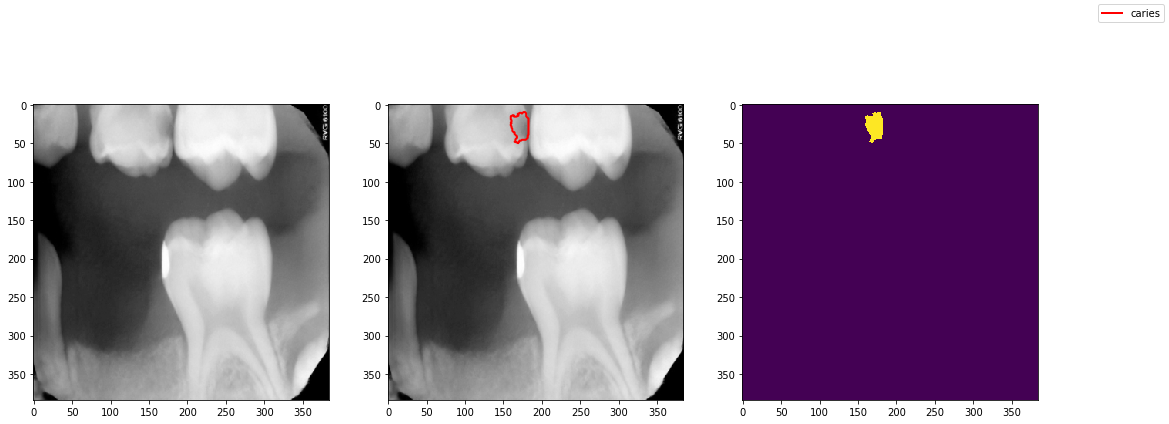

/home/rohan/Datasets/prior_clean/train/images/1.190926791160849.959...27404.45618687682615.627775..033815865/Molar3JawregionR/im.jpg
['/home/rohan/Datasets/prior_clean/train/masks/1.190926791160849.959...27404.45618687682615.627775..033815865/Molar3JawregionR/caries.jpg', '/home/rohan/Datasets/prior_clean/train/masks/1.190926791160849.959...27404.45618687682615.627775..033815865/Molar3JawregionR/caries3.jpg']


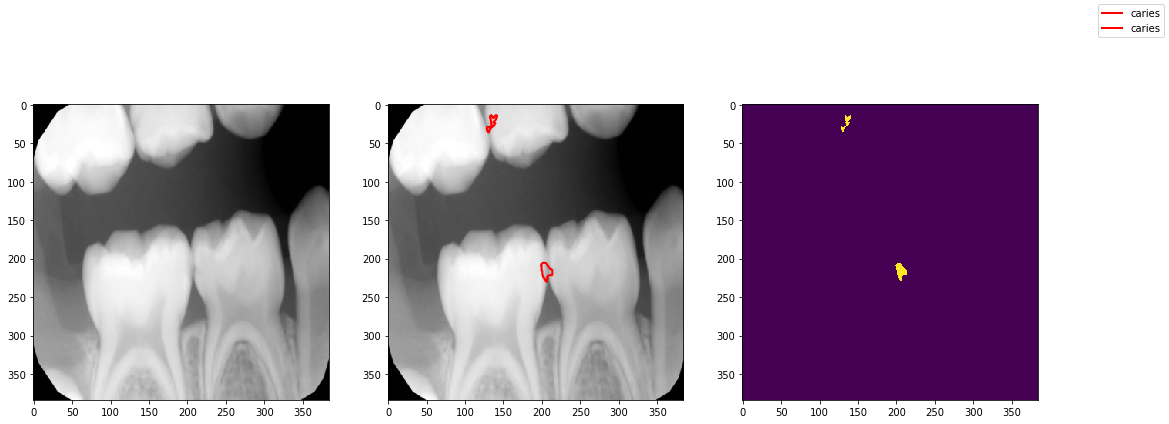

/home/rohan/Datasets/prior_clean/train/images/1.190926791160849.959...27404.45618687682615.627775..033815865/Molar3MandibleL/im.jpg
['/home/rohan/Datasets/prior_clean/train/masks/1.190926791160849.959...27404.45618687682615.627775..033815865/Molar3MandibleL/caries.jpg', '/home/rohan/Datasets/prior_clean/train/masks/1.190926791160849.959...27404.45618687682615.627775..033815865/Molar3MandibleL/caries3.jpg']


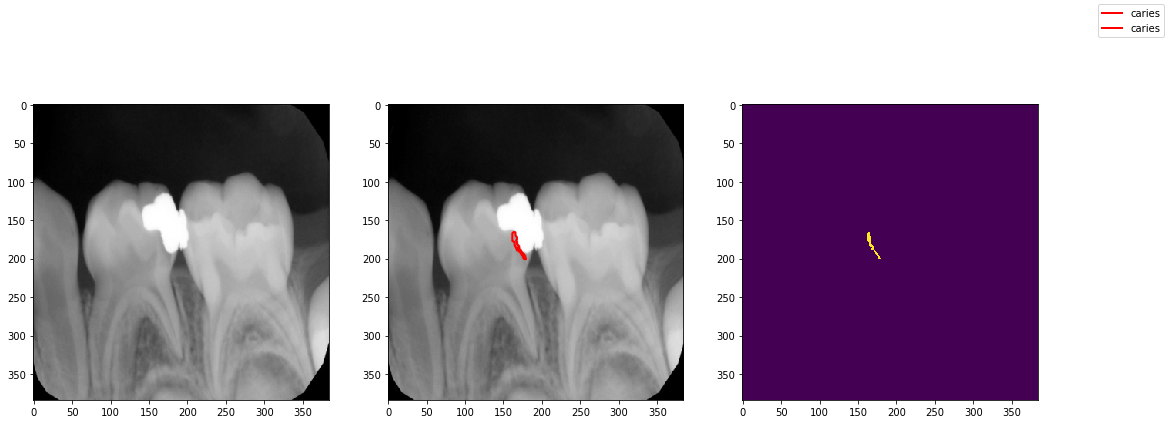

/home/rohan/Datasets/synthetic_prior_clean/train/images/1.190926791160849.959...34710.07612267682.6024071.586.3220753./Anterior1MandibleB/1/im.jpg
['/home/rohan/Datasets/synthetic_prior_clean/train/masks/1.190926791160849.959...34710.07612267682.6024071.586.3220753./Anterior1MandibleB/1/caries.jpg', '/home/rohan/Datasets/synthetic_prior_clean/train/masks/1.190926791160849.959...34710.07612267682.6024071.586.3220753./Anterior1MandibleB/1/caries2.jpg', '/home/rohan/Datasets/synthetic_prior_clean/train/masks/1.190926791160849.959...34710.07612267682.6024071.586.3220753./Anterior1MandibleB/1/caries3.jpg']


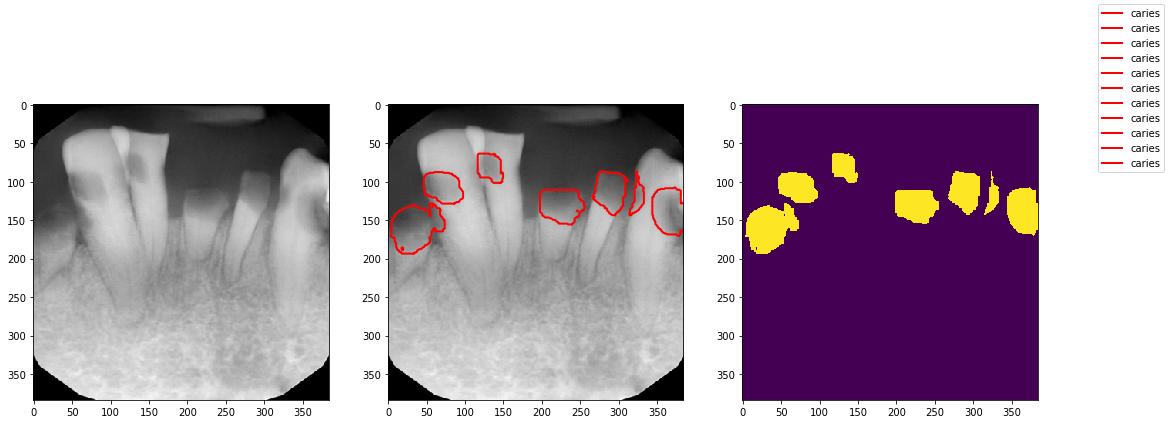

/home/rohan/Datasets/prior_clean/train/images/1.190926791160849.959...34710.07612267682.6024071.586.3220753./Anterior2MaxillaL/im.jpg
['/home/rohan/Datasets/prior_clean/train/masks/1.190926791160849.959...34710.07612267682.6024071.586.3220753./Anterior2MaxillaL/caries.jpg', '/home/rohan/Datasets/prior_clean/train/masks/1.190926791160849.959...34710.07612267682.6024071.586.3220753./Anterior2MaxillaL/caries2.jpg', '/home/rohan/Datasets/prior_clean/train/masks/1.190926791160849.959...34710.07612267682.6024071.586.3220753./Anterior2MaxillaL/caries3.jpg']


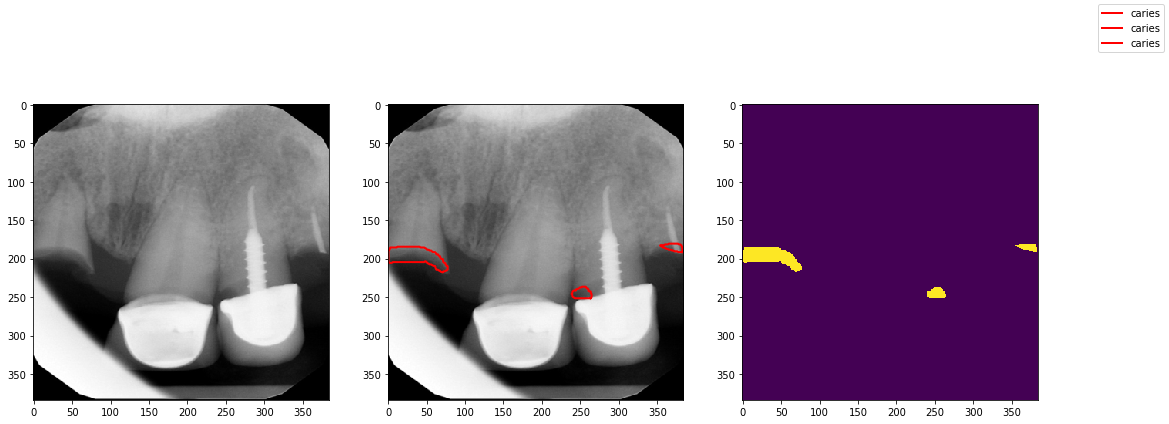

/home/rohan/Datasets/prior_clean/train/images/1.190926791160849.959...34710.07612267682.6024071.586.3220753./Anterior2MaxillaR/im.jpg
['/home/rohan/Datasets/prior_clean/train/masks/1.190926791160849.959...34710.07612267682.6024071.586.3220753./Anterior2MaxillaR/caries.jpg', '/home/rohan/Datasets/prior_clean/train/masks/1.190926791160849.959...34710.07612267682.6024071.586.3220753./Anterior2MaxillaR/caries2.jpg', '/home/rohan/Datasets/prior_clean/train/masks/1.190926791160849.959...34710.07612267682.6024071.586.3220753./Anterior2MaxillaR/caries3.jpg']


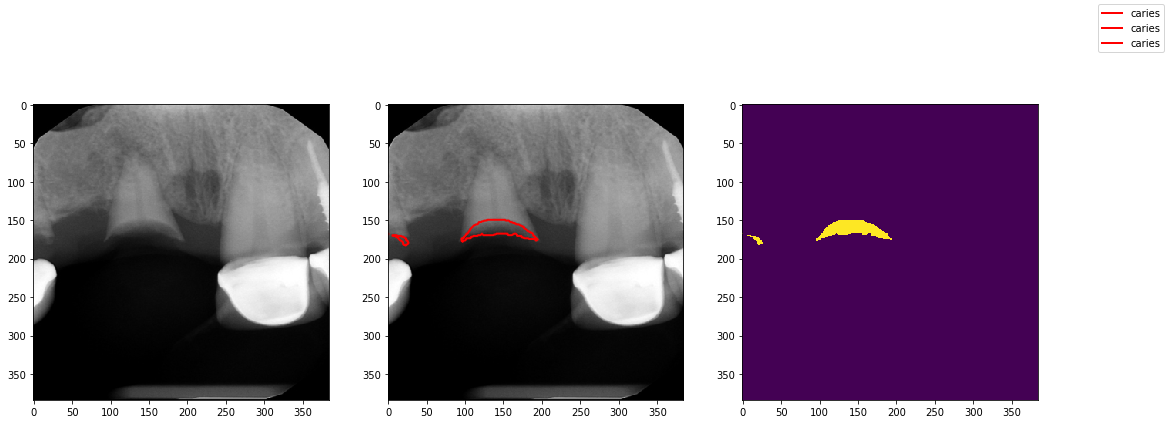

/home/rohan/Datasets/prior_clean/train/images/1.190926791160849.959...34710.07612267682.6024071.586.3220753./Anterior3MandibleL/im.jpg
['/home/rohan/Datasets/prior_clean/train/masks/1.190926791160849.959...34710.07612267682.6024071.586.3220753./Anterior3MandibleL/caries.jpg', '/home/rohan/Datasets/prior_clean/train/masks/1.190926791160849.959...34710.07612267682.6024071.586.3220753./Anterior3MandibleL/caries2.jpg', '/home/rohan/Datasets/prior_clean/train/masks/1.190926791160849.959...34710.07612267682.6024071.586.3220753./Anterior3MandibleL/caries3.jpg']


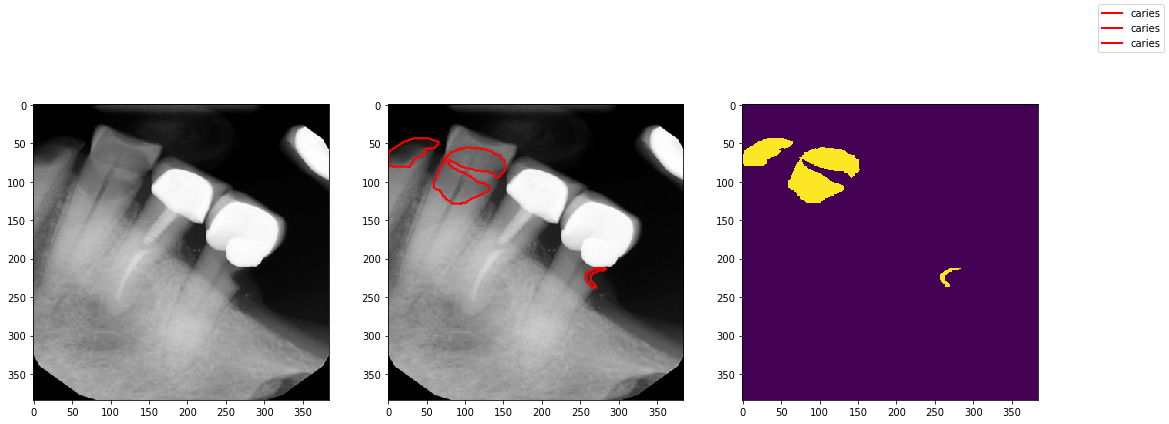

/home/rohan/Datasets/prior_clean/train/images/1.190926791160849.959...34710.07612267682.6024071.586.3220753./Anterior3MaxillaL/im.jpg
['/home/rohan/Datasets/prior_clean/train/masks/1.190926791160849.959...34710.07612267682.6024071.586.3220753./Anterior3MaxillaL/caries.jpg', '/home/rohan/Datasets/prior_clean/train/masks/1.190926791160849.959...34710.07612267682.6024071.586.3220753./Anterior3MaxillaL/caries2.jpg', '/home/rohan/Datasets/prior_clean/train/masks/1.190926791160849.959...34710.07612267682.6024071.586.3220753./Anterior3MaxillaL/caries3.jpg']


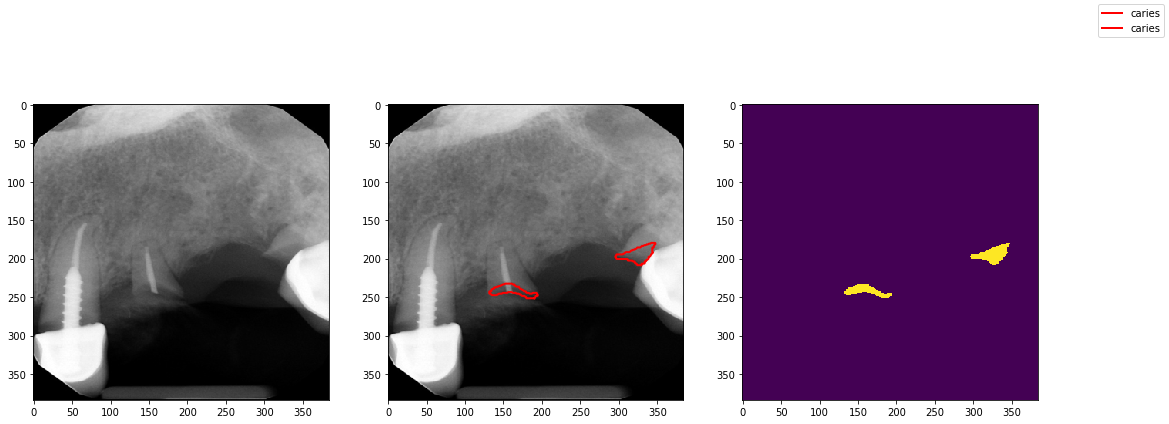

/home/rohan/Datasets/synthetic_prior_clean/train/images/1.190926791160849.959...34710.07612267682.6024071.586.3220753./Anterior3MaxillaR/0/im.jpg
['/home/rohan/Datasets/synthetic_prior_clean/train/masks/1.190926791160849.959...34710.07612267682.6024071.586.3220753./Anterior3MaxillaR/0/caries.jpg', '/home/rohan/Datasets/synthetic_prior_clean/train/masks/1.190926791160849.959...34710.07612267682.6024071.586.3220753./Anterior3MaxillaR/0/caries2.jpg', '/home/rohan/Datasets/synthetic_prior_clean/train/masks/1.190926791160849.959...34710.07612267682.6024071.586.3220753./Anterior3MaxillaR/0/caries3.jpg']


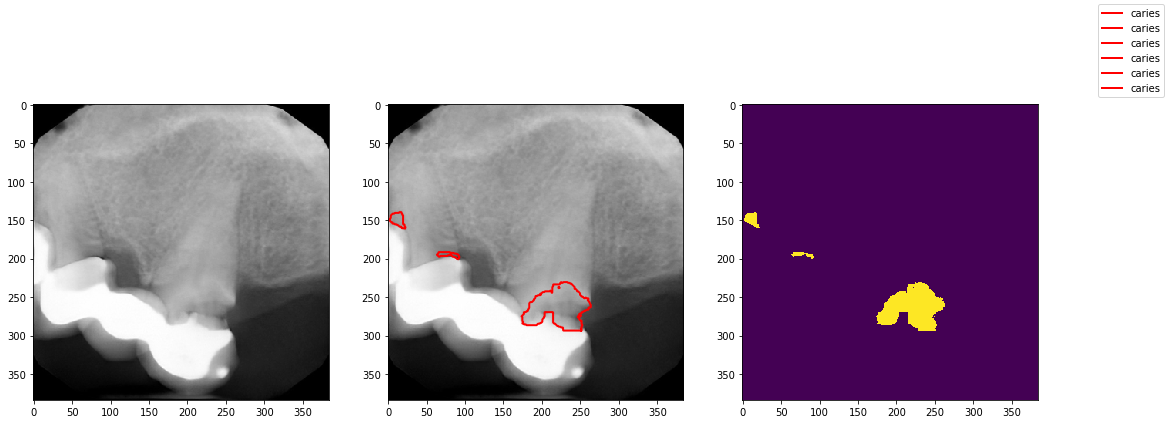

In [17]:
root_dir = '/home/rohan/Datasets/prior_clean/train/'
syn_root_dir = '/home/rohan/Datasets/synthetic_prior_clean/train/'

prior_data = RetraceDataLoader(root_dir, syn_root_dir, crop=True, length = 2000)


def get_contours(masks):
    contours_dict = {}
    for i in range(masks.shape[0]):
        contours = measure.find_contours(masks[i], 0.5)
        contours_dict[i]=contours
    return contours_dict

i = 0
for data in prior_data:
    
    if 1. in data['masks']:
        
#         ipdb.set_trace()
        img = data['image'][0]
        masks = data['masks']
        print(data['path'])
        print(data['mask_path'])
        
        msk_cnt = get_contours(masks)
        f,ax = plt.subplots(1,3, figsize=(18,7))
        ax[0].imshow(img, cmap='gray')
        ax[1].imshow(img, cmap='gray')
        ax[2].imshow(masks[0,:,:])
        for k, cnts in msk_cnt.items():
            if len(cnts)>0:
                for cnt in cnts:
                    ax[1].plot(cnt[:, 1], cnt[:, 0], linewidth=2, color=colors_dict['caries'], label = 'caries')
        
        plt.figlegend()
        
        plt.show()
        
        i +=1
        if i>10:
            break
        

In [19]:
rp = retrace_parser(root_dir)

In [22]:
all_imgfiles, all_maskfiles = rp.create_dataset()

Dataset length:  60178


In [24]:
len(all_maskfiles)

60178

In [26]:
count = 0
for mask_list in all_maskfiles:
    caries_count = 0
    for m in mask_list:
        label_name = m.split('/')[-1].split('.')[0]
        if 'caries' in label_name:
            count+=1
#     if caries_count>1:
#         count+=1

print(count)

58575
